In [ ]:
%matplotlib  inline  

import pandas as pandas
import cliffsDelta.cliffsDelta as cd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as scipy
import scipy.stats as stats
import pystan
import statsmodels.api as sm
import find_fit
import powerlaw
import sklearn.preprocessing as pp

Original dataset is available at http://www.mauricioaniche.com/scam2016/

First, a bit of data cleaning. I want to eventually use the lines of code as a predictor, so we merge that into the original metrics data. Some rows are missing either a metric or a LOC count, so we drop those.

In [3]:
roles = {0:"none",1:"controller", 2:"dao", 3:"service", 4:"entity", 5:"component"}
roles_lst = list(roles.values())
# roles_num = range(len(roles))
# role_dict = dict(zip(roles_num, roles))
spring_columns = ["project", "file", "class", "type", "test", "role", "cbo", "dit", "lcom", "noc", "nom", "rfc", "wmc"]

# load data
# N = 63525
spring = pandas.read_csv('data/metrics/spring.csv', header=None, names=spring_columns)
# N = 60701
sloc = pandas.read_csv('data/metrics/spring-sloc2-java.csv', usecols=['loc','file'])

# inner = drop NaN values
# N = 59760
final = spring.merge(sloc, on='file', how='inner')
# final.replace({'role': role_dict}, inplace=True)
# Strict replication would need to use DataFrame 'spring' and not 'final', due to merge
cbo_pop = final.loc[:,['test','type','cbo','role','loc']]
cbo_pop_controller = cbo_pop.query("test == 0 and type == 'class' and role != 1")

cbo_controller = cbo_pop.query("role == 1")
data = pandas.Series(cbo_controller['cbo'])



In [6]:
#len(final.query("project=='tatami-team1'"))
# len(final)
# final.role
assert(len(final.query("role == 0 and cbo ==0"))==5256) # 5256 originally - all no role

We have 120 projects in the \cite{aniche16} dataset, and a wide range of values for N (number of files). Some projects are very tiny. The total file count of the smallest is 28, and the number of controller files (for example) is 18.

In [7]:
# clean projects with no controllers
print("before: final is size {}".format(len(final)))
projects = final.project.str.strip().unique()
for name in projects:
    query_string = "project == '"+ name + "' and role == 1"
    num = len(final.query(query_string))
    if num == 0: # no controllers, hard to do regression
        print ("Project {} has no Controllers".format(name))
        final.drop(final[final.project==name].index,inplace=True)
print("after: " + str(len(final)))
final = final.reset_index(drop=True)
#archiva icemobile poulpe openrdf-sesame  simple-petstore

before: final is size 59761
Project archiva has no Controllers
Project icemobile has no Controllers
Project poulpe has no Controllers
Project openrdf-sesame has no Controllers
Project simple-petstore has no Controllers
after: 56106


In [8]:
#debug
len(final.query("role == 1 and cbo ==0"))
role_code = final.role
len(role_code)
# len(final)

56106

In [9]:
# reshape the Role field into onehot encoding (binarized)
# an array of size 6 where a 1 indicates True for each role
role_code = final.role

lb = pp.LabelBinarizer().fit(role_code.values.reshape(-1,1))
binarized = lb.transform(role_code)
temp = pandas.DataFrame(binarized,columns=roles_lst)
#using indices assumes equal size
# print(len(temp))


In [10]:
# merge 1-hot into final
final = final.merge(temp,left_index=True,right_index=True)


In [91]:
final

,project,file,class,type,test,role,cbo,dit,lcom,noc,nom,rfc,wmc,loc,none,controller,dao,service,entity,component
0,tatami-team1,/media/dsk1/webapps-springmvc/tatami-team1/src...,fr.ippon.tatami.domain.validation.ContraintsUs...,interface,0,0,0,1,0,0,0,0,0,3,1,0,0,0,0,0
1,tatami-team1,/media/dsk1/webapps-springmvc/tatami-team1/src...,fr.ippon.tatami.repository.cassandra.Cassandra...,class,0,2,18,1,0,0,4,36,26,101,0,0,1,0,0,0
2,tatami-team1,/media/dsk1/webapps-springmvc/tatami-team1/src...,fr.ippon.tatami.service.UserService,class,0,3,17,1,0,0,13,58,38,210,0,0,0,1,0,0
3,tatami-team1,/media/dsk1/webapps-springmvc/tatami-team1/src...,fr.ippon.tatami.service.GroupService,class,0,3,15,1,0,0,8,50,26,132,0,0,0,1,0,0
4,tatami-team1,/media/dsk1/webapps-springmvc/tatami-team1/src...,fr.ippon.tatami.security.TatamiUserDetails,class,0,0,1,2,0,0,4,0,4,23,1,0,0,0,0,0
5,tatami-team1,/media/dsk1/webapps-springmvc/tatami-team1/src...,fr.ippon.tatami.repository.cassandra.Cassandra...,class,0,2,8,2,1,0,2,7,2,35,0,0,1,0,0,0
6,tatami-team1,/media/dsk1/webapps-springmvc/tatami-team1/src...,fr.ippon.tatami.security.TatamiLdapAuthenticat...,class,0,0,14,2,1,0,3,23,13,71,1,0,0,0,0,0
7,tatami-team1,/media/dsk1/webapps-springmvc/tatami-team1/src...,fr.ippon.tatami.test.application.ApplicationEl...,class,0,0,4,1,0,0,1,2,1,20,1,0,0,0,0,0
8,tatami-team1,/media/dsk1/webapps-springmvc/tatami-team1/src...,fr.ippon.tatami.repository.MentionlineRepository,interface,0,0,2,1,1,0,2,0,2,8,1,0,0,0,0,0
9,tatami-team1,/media/dsk1/webapps-springmvc/tatami-team1/src...,fr.ippon.tatami.repository.TagFollowerRepository,interface,0,0,0,1,3,0,3,0,3,7,1,0,0,0,0,0


In [11]:
# len(final.query("role == 1 and cbo ==0"))
len(final.query("controller == 1 and cbo ==0"))

0

In [12]:
projects = final.project.str.strip().unique()
proj_num = len(projects)
project_lookup = dict(zip(projects, range(proj_num)))
project = final['proj_code'] = final.project.replace(project_lookup).values
role_code = final.role

In [13]:
# remove Zeros for log to work
epsilon = 0.1
cbo = final.cbo
final['log_cbo'] = log_cbo = np.log(cbo + epsilon).values
sloc = final['loc']
final['log_sloc'] = log_sloc = np.log(sloc + epsilon).values


In [14]:
final.query("role == 2 and cbo ==0")

,project,file,class,type,test,role,cbo,dit,lcom,noc,...,loc,none,controller,dao,service,entity,component,proj_code,log_cbo,log_sloc


18

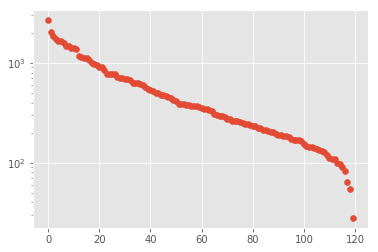

In [96]:
# show the values of N
s = pandas.Series(spring['project']).value_counts() 
ax = plt.gca()
ax.scatter(range(len(s)),s)
ax.set_yscale('log')
# find number of controllers in smallest
twogx_df = spring[spring['project'] == '2gx_demo']
len(twogx_df[twogx_df['role'] == 1]) # 18

In [97]:
### for testing - reduce data set
# final = final[final.proj_code < 10]
# project = final['proj_code'] = final.project.replace(project_lookup).values
# projects = final.project.str.strip().unique()
# proj_num = len(projects)
# project_lookup = dict(zip(projects, range(proj_num)))
# role_code = final.role
###


The violin plot can show us a rough sense for how the data is distributed. We'll plot it on a log scale for CBO (adding $\epsilon=0.1$ to the zeros, which is not necessarily the best idea). The log transformed value will then be known as LCBO. See [Modeling the Spike at Zero](#spikezero)

In [33]:
from matplotlib.ticker import FuncFormatter, MaxNLocator
def format_fn(tick_val,tick_pos):
    if int(tick_val) in role_code:
        return roles[tick_val]
    else:
        return ''

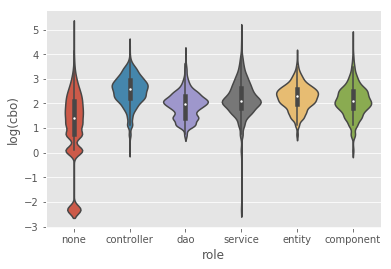

In [34]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax = sns.violinplot(role_code, log_cbo, ax=ax1) #, data=final,
ax.set_ylabel('log(cbo)')
ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
#ax.set_xlabel(roles_lst)
fig.savefig('violin.pdf')

In [32]:
roles

{0: 'none',
 1: 'controller',
 2: 'dao',
 3: 'service',
 4: 'entity',
 5: 'component'}

Text(0,0.5,'log(sloc)')

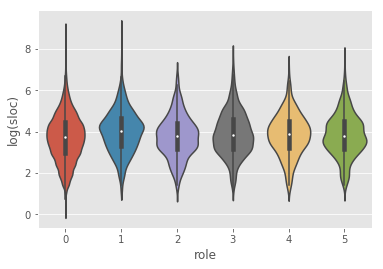

In [16]:
ax = sns.violinplot(role_code, log_sloc)
ax.set_ylabel('log(sloc)')

## A Multi-Level Model
The original approach was to compare each of the 5 roles against the *entire* set of remainig files for the CBO metric. This pairwise comparison was evaluated with the Wilcoxon test (R's `wilcox.test` function, to be exact). I think this is equivalent to the Mann-Whitney test.  Let's try to replicate that result for these files. 

As a sanity check of the Python Cliff's Delta calc, let's look at the Controller vs Population calculation from the paper. Table 1 reports CBO for Controller vs Pop of 0.6591.

In [ ]:
%%timeit -r1 -n1
# compare CBO of Role=Controller to CBO of remainder
mann_dict = {}
cliff_dict = {}
vals = range(1,6)
for role in vals:
    for role2 in vals:
        first = cbo_pop[(cbo_pop.role == role)]
        other = cbo_pop[(cbo_pop.role == role2)]
        key = roles[role] +'-'+ roles[role2]
        mann_dict[key] = stats.mannwhitneyu(first['cbo'],other['cbo'])
        cliff_dict[key] = cd.cliffsDelta(first['cbo'],other['cbo'])
delta, effsize = cd.cliffsDelta(cbo_controller['cbo'],cbo_pop_controller['cbo'])
statistic, pvalue = stats.mannwhitneyu(cbo_pop_controller['cbo'],cbo_controller['cbo'])

In [ ]:
print(cd.cliffsDelta(cbo_controller['cbo'],cbo_pop_controller['cbo']))
print(scipy.stats.mannwhitneyu(cbo_pop_controller['cbo'],cbo_controller['cbo']))


In [ ]:
# first, the lognormal
data = pandas.Series(cbo_controller['cbo'])
fit = powerlaw.Fit(data, discrete=True)
####
fit.distribution_compare('power_law', 'lognormal')
fig = fit.plot_ccdf(linewidth=3, label='Empirical Data')
fit.power_law.plot_ccdf(ax=fig, color='r', linestyle='--', label='Power law fit')
fit.lognormal.plot_ccdf(ax=fig, color='g', linestyle='--', label='Lognormal fit')
####
fig.set_ylabel(u"p(X≥x)")
fig.set_xlabel("CBO")
handles, labels = fig.get_legend_handles_labels()
fig.legend(handles, labels, loc=3)

figname = 'FigLognormal'
# savefig(figname+'.eps', bbox_inches='tight')
#savefig(figname+'.tiff', bbox_inches='tight', dpi=300)


In [ ]:
import importlib
importlib.reload(find_fit)
find_fit.plot_fits(pandas.Series(data), title='Log-CBO with best fit distributions', xlab='Log-CBO')
# plt.savefig('fit-distr.pdf', dpi=300)



This tells us to use an inverse gamma, but the Normal (of the log data) is almost as good a fit. We can also use the probplot approach with Quantile-Quantile graphs. Here we compare our data to the theoretical model of each distribution. A perfect fit implies a diagonal 45 degree match. QQ plots show divergence from the predicted (theoretical) values. 

In [ ]:
# using StatModels
fig1 = sm.qqplot(data, stats.norm, fit=True, line='45')
fig1.suptitle('Normal QQ')
fig2=sm.qqplot(data, stats.lognorm, fit=True, line='45')
fig2.suptitle('LogNormal QQ')
fig3 = sm.qqplot(data, stats.powerlaw, fit=True, line='45')
fig3.suptitle('Powerlaw QQ')
fig4 = sm.qqplot(log_sloc, stats.lognorm, fit=True, line='45')
fig4.suptitle('LogNormal QQ-SLOC')

There's some weirdness down at the extreme end---this is where the powerlaw fit would likely be more suitable. The QQ plot is showing that the actual values are greater than predicted by a lognormal curve would show (recall that the lognormal is modeled by  $X \sim e^Y$).  For the purposes of the remainder of the paper, however, it does not detract from the argument to consider the log of the metric values.

# Multi-level models
In general, the approach taken in the SATT paper is to compare, using a non-parametric test, the ordered list of metric values for a given architectural role against (a) a single other architectural role and (b) all other data. The authors used the results to suggest that there is a significant difference in metric scores (CBO, in our case) given a particular architectural role.

Two things are unsatisfying with this approach. One, it does not make use of the lognormal distribution of the data to conduct a more substantive analysis of the data. Two, the large degrees of researcher freedom make it uncertain whether such a result is replicable.

Multilevel or *hierarchical* models allow us to treat this problem differently. One way to reprhase the problem in a parametric format is to ask whether the distribution parameters (brodaly, shape and location of central tendency; in the normal case, mean and variance (sigma)) are different from one set of data to another. There are frequentist tests, such as the two-tailed t-test, that could do this; another way is to fit a regression line to the data and evaluate to what extent the regression coefficients (the line's *slope* and *intercept*) differ. 

Here are three ways to do this.

## The Prediction Task
Our task is to predict a given project's mean LCBO score. Our predictor is the file's architectural role; later, we can add a predictor using lines of code. THe hyp, we would expect (based on Aniche et al) that (log) CBO would be higher given 
<!--all else equal, a file with more LOC is expected to have more coupling. -->

The hierarchy in this example is files within projects.  

## Full Pooling
Full pooling is a global assessment of differences. We don't divide our dataset at all, but rather look at a single regression model. We predict CBO score, $y$, as a function of role (see the extension below for the addition of SLOC as a predictor):
$ y_i = \alpha + \beta x_i + \epsilon_i$


First, we model the data in Stan. Here I follow the model approach described by [Chris Fonnesbeck](https://github.com/fonnesbeck/stan_workshop_2016/blob/master/notebooks/Multilevel%20Modeling.ipynb)

In [42]:
pooled_data = """
data {
  int<lower=0> N; 
  vector[N] x;
  vector[N] y;
}
"""


Initialize the parameters, which in this case are the linear model coefficients and the normal scale parameter. 

In [43]:
pooled_parameters = """
parameters {
  vector[2] beta;
  real<lower=0> sigma;
} 
"""

Finally, using the standard normal linear model, we know that all responses y can be modeled as a normal disttirubtion whose mean is the linear function of x, and whose variance sigma is constant. Accordingly, we model the log-CBO measurements as a normal (lognormal distribution, hence normal of the log) distribution with a mean that is a function of the role played.


In [39]:
pooled_model = """
model {
  y ~ normal(beta[1] + beta[2] * x, sigma);
}
"""

We then pass the code, data, and parameters to the stan function. The sampling requires specifying how many iterations we want, and how many parallel chains to sample. Here, we will sample 2 chains of length 1000. 

In [40]:
pooled_data_dict = {'N': len(log_cbo),
               'x': role_code,
               'y': log_cbo}

In [46]:
# %%timeit -r1 -n1

compiled_model = pystan.stanc(model_code=pooled_data + pooled_parameters + pooled_model)
pool_sm = pystan.StanModel(stanc_ret=compiled_model)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dd6a876b770652d53bdcc0546345af4b NOW.


In [47]:
%%time
# you can reuses the compiled model with new data

pooled_fit = pool_sm.sampling(data=pooled_data_dict, iter=1000, chains=2)

CPU times: user 49.3 ms, sys: 65.6 ms, total: 115 ms
Wall time: 22.9 s


In [48]:
pooled_sample = pooled_fit.extract(permuted=True)
# we assume the resulting sample is normally distributed
b0, m0 = pooled_sample['beta'].T.mean(1)

In the Bayesian context, what we have created is a probability distribution on the posterior values (the unknown parameters $\beta$ and $\sigma$). We aren't getting point estimates, but rather distributions. Hence, in order to get a sense for what the probability masses around (due to the central limit theorem, we get normal distributions for these parameters). Thus we sample from the posterior distribution represented by $\textsf{pooled_fit}$ and show the range of values.

I then plot the values as a regression line, using the new parameters b0 and m0 for the slope and intercept of the regression line.

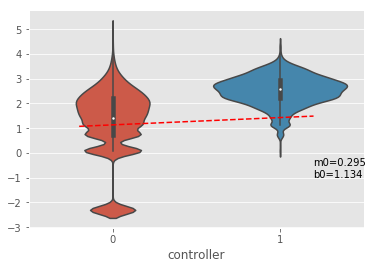

In [49]:
#plt.scatter(final.controller, log_cbo)
fig = plt.figure()
ax1 = fig.add_subplot(111)

import seaborn as sns
# in the violinplot, "0" means "not controller" which is a bit different from the original paper
ax = sns.violinplot(final.controller, log_cbo)
xvals = np.linspace(-0.2, 1.2)
ax.plot(xvals, m0*xvals+b0, 'r--')
plt.text(1.2,-1,"m0={0:.3f}\nb0={1:.3f}".format(m0,b0))

fig.savefig('pooled-regress.pdf')



The interpretation of this regression result says that in a pooled model, we would expect an average LCBO of 1.144 (CBO of 3.14) if there were no controllers; and the controller predictor causes a `exp(0.0291)= 1.03` increase in CBO.

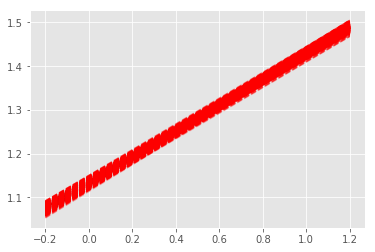

In [133]:
# here we plot several of the samples to show the variance sigma
fig = plt.figure()
ax1 = fig.add_subplot(111)
xvals = np.linspace(-0.2, 1.2)
for i in range(1000):
    bi,mi = pooled_sample['beta'][i]
    ax1.plot(xvals, mi*xvals+bi, 'r--',alpha=0.4)


# fig.savefig('pooled-regress.pdf')


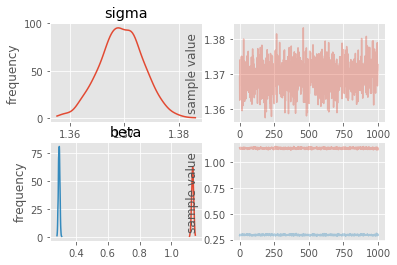

In [134]:
pooled_fit.plot(pars=['sigma', 'beta']);

In [135]:
print(pooled_fit)

Inference for Stan model: anon_model_dd6a876b770652d53bdcc0546345af4b.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0]   1.13  2.7e-4 6.2e-3   1.12   1.13   1.13   1.14   1.15    546    1.0
beta[1]    0.3  1.9e-4 4.7e-3   0.29   0.29    0.3    0.3    0.3    602    1.0
sigma     1.37  1.3e-4 4.0e-3   1.36   1.37   1.37   1.37   1.38   1000    1.0
lp__    -4.6e4    0.05   1.16 -4.6e4 -4.6e4 -4.6e4 -4.6e4 -4.6e4    479    1.0

Samples were drawn using NUTS at Mon Jan 29 22:16:44 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [136]:
scipy.stats.linregress(role_code,log_cbo)

LinregressResult(slope=0.29551405721680779, intercept=1.1336694034685346, rvalue=0.2659737176019083, pvalue=0.0, stderr=0.004521792799878686)

## Unpooled
We could go to the other extreme, and model the data per project (120 projects). Each project gets a separate regression model, and we can compare the co-efficients for each one.

$y_i = \alpha_{i[j]} + \beta x_i + \epsilon_i $

The difference between these two approaches is a bias-variance tradeoff. In the fully pooled model, we bias the data to the larger instances (the value for the number of files per project, which is our number of uinique measures, range from 26 files to 2677 files). The subtle variance per project, which may demonstrate confounding effects (e.g., that some unmodeled predictor is partly responsible for the value of LCBO), is ignored in this model.

By contrast, in the unpooled approach, we allow total variance, at the expense of high variance (and possibly misleading data) in the smaller samples. McIlreath (\cite{mcilreath16}) calls this "anterograde amnesia" since we 'forget' what we learned from the previous projects. 

In [21]:
# unpooled *change 10 to 120 in production*
unpooled_model = """
data {
  int<lower=0> N; 
  int<lower=1,upper=115> project[N];
  vector[N] x;
  vector[N] y;
} 
parameters {
  vector[115] a;
  real beta;
  real<lower=0,upper=100> sigma;
} 
transformed parameters {
  vector[N] y_hat;

  for (i in 1:N)
    y_hat[i] = beta * x[i] + a[project[i]];
}
model {
  y ~ normal(y_hat, sigma);
}
"""

unpooled_data = {'N': len(log_cbo),
                 'project': project+1,  # Stan counts starting at 1
                 'x': final.controller,
                 'y': log_cbo}

compiled_unpooled_model = pystan.stanc(model_code= unpooled_model)
unpooled_model = pystan.StanModel(stanc_ret=compiled_unpooled_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4f454acd68b403fa36dad520bac8ac42 NOW.


In [53]:
# %%timeit 
unpooled_fit = unpooled_model.sampling(data=unpooled_data, iter=1000, chains=2)

In [65]:
unpooled_estimates = pandas.Series(unpooled_fit['a'].mean(0), index=project_lookup)
unpooled_se = pandas.Series(unpooled_fit['a'].std(0), index=project_lookup)
order = unpooled_estimates.sort_values().index

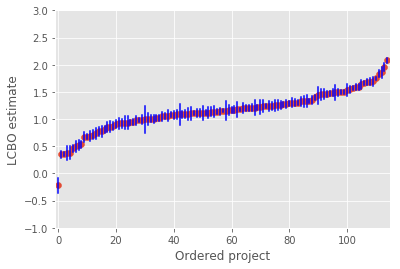

In [66]:
plt.scatter(range(len(unpooled_estimates)), unpooled_estimates[order])
for i, m, se in zip(range(len(unpooled_estimates)), unpooled_estimates[order], unpooled_se[order]):
    plt.plot([i,i], [m-se, m+se], 'b-')
#cahnge back to 120
plt.xlim(-1,115); plt.ylim(-1,3)
plt.ylabel('LCBO estimate');plt.xlabel('Ordered project');

In [ ]:

unpooled_estimates['2gx_demo']

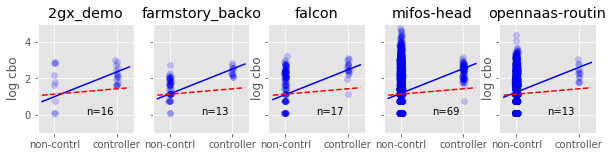

In [143]:
# sample_projects = list(project_lookup.keys())
# a set of projects with 1-3 being tiny, and 4-5 being large
wide_variance_proj = ['2gx_demo','farmstory_backoffice','falcon','mifos-head','opennaas-routing-nfv']

fig, axes = plt.subplots(1, 5, figsize=(10, 2), sharey=True, sharex=True)
axes = axes.ravel()
m = unpooled_fit['beta'].mean(0)
for i,c in enumerate(wide_variance_proj):
    y = final.log_cbo[final.project==c]
    x = final.controller[final.project==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.2, c='b')
    
    # No pooling model
    b = unpooled_estimates[c]
    
    # Plot both models and data
    xvals = np.linspace(-0.2, 1.2)
    interim = final.controller[final.project==c]
    n = pandas.Series(interim).value_counts()[1]
    axes[i].plot(xvals, m*xvals+b, 'b-') #unpooled
    axes[i].plot(xvals, m0*xvals+b0, 'r--') #pooled
    axes[i].set_xticks([0,1])
    axes[i].text(0.5,0,'n={}'.format(n))
    axes[i].set_xticklabels(['non-contrl', 'controller'])
    axes[i].set_ylim(-1, 5)
    axes[i].set_title(c[0:15])
    if not i%2:
        axes[i].set_ylabel('log cbo')

In [ ]:
#final[final.project=c]
pandas.Series(interim).value_counts()

# Understanding the Differences
We now have two different models of what we would expect a file's LCBO to be. In the *pooled* approach, it is a function of the global distribution of CBO metric scores, averaged over all projects (i.e., we could say we understand CBO for a java file sampled at random from the original dataset). In the *unpooled* approach, a file's CBO score would be a function of the CBO distribution over all other files *in that project*. 

Neither is very satisfying. We know from previous research TODO CITATION NEEDED that software measurement is a highly contextual activity. Indeed, that is the very message of the original SATT paper. However, it would be silly to think that there was *no* global model that was applicable; developers, the Java language, the *naturalness* of software \cite{hindle} all suggest commonalities. Most importantly, some projects have very small N (number of files), so any measurement is going to exhibit a high degree of variance.

Let's see what that looks like. In the figure below, we are looking at a subset of 10 projects. In each plot you can see the value of N, where N = # of controller files (i.e., annotated with Spring's @controller mark).  The dashed red line is our regression line for the pooled model, and the blue line the unpooled (project specific) regression. It is clear that these two rarely line up well.

## Partial Pooling
Partial pooling, as you might expect, combines the two. It gives nuance we think exists because of local effects from architectural role, but weights that by the global mean. We are adjusting our local estimate *conditional* on the global estimate (which itself is conditioned on the new local values it encounters). The simplest approach to partial pooling is to take a weighted average and apply that to the global estimate. Smaller samples then have less impact on our global estimate.

If we instead think about our prediction task as a regression, another way to account for global trends in a local estimate is to vary either the slope of the regression line, or to vary the intercept of the line. Recall that our **global**/pooled regression equation predicts $y_i$, an observation at point i, to be 

$ y_i = \alpha + \beta x_i + \epsilon_i$


### Varying Intercept
Here we allow the intercept parameter $\alpha$ to vary with each project according to a random effect (random as in 'random variable').

In our unpooled model $y_i = \alpha_{i[j]} + \beta x_i + \epsilon_i $, we allowed the underlying Bayesian inference engine (Hamiltonian Monte Carlo) to estimate our parameters for the regression equation (i.e., $m_0$ and $b$). In a multilevel approach, rather than producing point estimates for these parameters, we instead model them with further probability distributions (i.e., the intercept $b$ of the regression for project $j$ is modeled as a normal distribution, whose parameters $\mu$ and $\sigma$ we now attempt to fit with the Bayesian inference engine (hyperparameters)).

Our regression model then adds a distributions for random/varying effects on the intercept $\alpha$:

$\alpha_{i[j]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2$) and models the individual project error $\epsilon_i$ as $\epsilon_i \sim N(0, \sigma^2_y$).

Read the expression $\epsilon_i \sim N(0, \sigma^2_y$) as "the error parameter epsilon is modeled by a Normal distribution with parameters mean = 0 and variance sigma squared". This is leveraging the probabilistic programming approach of simulating our posterior distribution using Hamiltonian Monte Carlo.


In [144]:

# i'm not clear why 100 is the uniform shape here
varying_intercept = """
data {
  int<lower=0> J; 
  int<lower=0> N; 
  int<lower=1,upper=J> project[N];
  vector[N] x;
  vector[N] y;
} 
parameters {
  vector[J] a;
  real b;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {

  vector[N] y_hat;

  for (i in 1:N)
    y_hat[i] = a[project[i]] + x[i] * b;

}
model {
  sigma_a ~ uniform(0, 100);
  a ~ normal (mu_a, sigma_a);

  b ~ normal (0, 1);

  sigma_y ~ uniform(0, 100);
  y ~ normal(y_hat, sigma_y);
}
"""

In [146]:
varying_intercept_data = {'N': len(log_cbo),
                          'J': len(projects),
                          'project': project+1,  # Stan counts starting at 1
                          'x': final.controller,
                          'y': log_cbo}

In [147]:
# %%time
varying_intercept_fit = pystan.stan(model_code=varying_intercept, data=varying_intercept_data, iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cd7c67c43e453abac639b25078fccf87 NOW.


CPU times: user 3.27 s, sys: 8.54 s, total: 11.8 s
Wall time: 7min 30s


In [ ]:
len(sample_projects)

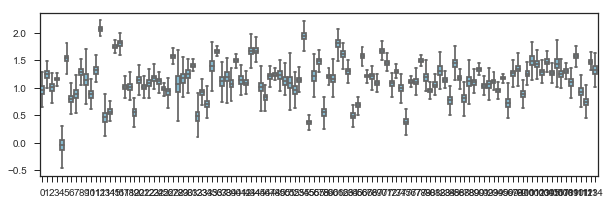

In [148]:
a_sample = pandas.DataFrame(varying_intercept_fit['a'])
sns.set(style="ticks", palette="muted", color_codes=True)

# Plot the orbital period with horizontal boxes
plt.figure(figsize=(10, 3))
sns.boxplot(data=a_sample, whis=np.inf, color="c")

The whisker plot shows how the intercept parameter $\alpha$ varies over the separate projects.

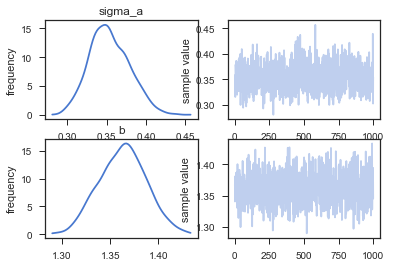

In [149]:
varying_intercept_fit.plot(pars=['sigma_a', 'b']);



In [68]:
# varying_intercept_fit['b'].mean()
xvals = np.arange(2)
bp = varying_intercept_fit['a'].mean(axis=0) # intercept
mp = varying_intercept_fit['b'].mean() # slope = constant
for bi in bp:
    plt.plot(xvals, mp*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1,1.1);


NameError: name 'varying_intercept_fit' is not defined

The controller coefficient $\beta$/b has a value of 1.41, which can be interpreted as saying that Controllers in our dataset have a (exp(1.41)= 4.1 greater CBO value than non-Controller code. Recall that in this varying intercept model, this parameter b is fixed for all projects.

If we look at a comparison of the partially pooled, varying intercept model against the pooled estimate, we see how the estimates are more reasonable. The unpooled estimate is very similar: we did not allow slope to vary, and intercept is determined by the sufficiently large number of data points that are not controllers.

NameError: name 'mp' is not defined

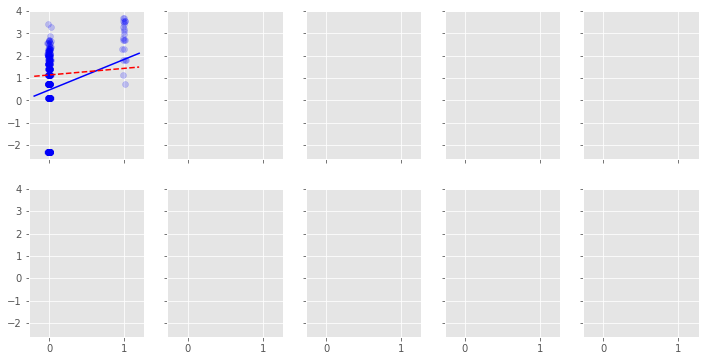

In [67]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6), sharey=True, sharex=True)
goodPerfoming_variance_proj = sample_projects = ['netvogue','Condominio','ROMS']

axes = axes.ravel()
m = unpooled_fit['beta'].mean(0)
for i,c in enumerate(sample_projects):
    y = final.log_cbo[final.project==c]
    x = final.controller[final.project==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.2, c='b')
    
    # No pooling model
    b = unpooled_estimates[c] 
    interim = final.controller[final.project==c]
    n = pandas.Series(interim).value_counts()[1]
    xvals = np.linspace(-0.2, 1.2)
    # Unpooled estimate
    axes[i].plot(xvals, m*xvals+b,'b-')
    # Pooled estimate
    axes[i].plot(xvals, m0*xvals+b0, 'r--')
    # Partial pooling estimate
    axes[i].plot(xvals, mp*xvals+bp[project_lookup[c]], 'k:')
    axes[i].set_xticks([0,1])
    axes[i].text(0.5,0,'n={}'.format(n)) 
    axes[i].set_xticklabels(['non-contrl', 'controller'])
    axes[i].set_ylim(-1, 5)
    axes[i].set_title(c[0:15])
    if not i%2:
        axes[i].set_ylabel('log CBO')

### Varying Slopes In Addition To Intercepts
Here, along with the varying intercept, we vary the slope parameter $\beta$ with each project. The practical impact of this will be to allow the projects to vary according to how the controller/non-controller predictor influences the reading. Our regression equation is 

$$y_i = \alpha_{j[i]} + \beta_{j[i]} x_{i} + \epsilon_i$$





In [16]:
varying_intercept_slope = """
data {
  int<lower=0> N;
  int<lower=0> J;
  vector[N] y;
  vector[N] x;
  int<lower=1,upper=J> project[N];
}
parameters {
  real<lower=0> sigma;
  real<lower=0> sigma_a;
  real<lower=0> sigma_b;
  vector[J] a;
  vector[J] b;
  real mu_a;
  real mu_b;
}

model {
  mu_a ~ normal(0, 100);
  mu_b ~ normal(0, 100);

  a ~ normal(mu_a, sigma_a);
  b ~ normal(mu_b, sigma_b);
  y ~ normal(a[project] + b[project].*x, sigma);
}
"""

In [17]:
%%time
varying_intercept_slope_data = {'N': len(log_cbo),
                          'J': len(projects),
                          'project': project+1,  # Stan counts starting at 1
                          'x': final.controller,
                          'y': log_cbo}

compiled_partial_model = pystan.stanc(model_code=varying_intercept_slope)
partial_model = pystan.StanModel(stanc_ret=compiled_partial_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ae7d507da253e467cd9f7c15eb545bae NOW.


CPU times: user 1.09 s, sys: 76 ms, total: 1.16 s
Wall time: 41.4 s


In [51]:
# %%timeit 
varying_intercept_slope_fit = partial_model.sampling(data=varying_intercept_slope_data, iter=1000, chains=2)

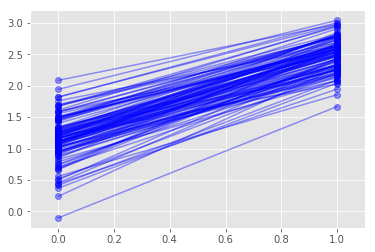

In [69]:
xvals = np.arange(2)
slopes_partial = varying_intercept_slope_fit['b'].mean(axis=0)
intercepts_partial = varying_intercept_slope_fit['a'].mean(axis=0)
for bi,mi in zip(intercepts_partial,slopes_partial):
    plt.plot(xvals, mi*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1, 1.1);
plt.savefig('slopes.pdf')

In [ ]:
varying_intercept_slope_fit.plot(pars=['sigma_a', 'b']);
plt.savefig('eval-fit.pdf')

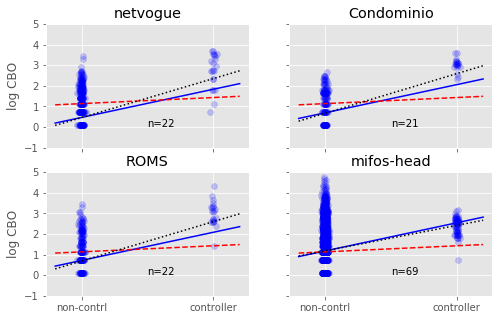

In [84]:
fig, axes = plt.subplots(2, 2, figsize=(8, 5), sharey=True, sharex=True)
axes = axes.ravel()
slope_unpooled = unpooled_fit['beta'].mean(0)
intercept_pooled, slope_pooled = pooled_sample['beta'].T.mean(1)
wide_variance_proj = goodPerfoming_variance_proj = ['netvogue','Condominio','ROMS','mifos-head']#,'opennaas-routing-nfv']

for i,c in enumerate(wide_variance_proj):
    y = final.log_cbo[final.project==c]
    x = final.controller[final.project==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.2, c='b')
    
    # Unpooled model has project-specific intercept, global slope
    intercept_unpooled = unpooled_estimates[c] 
    
    interim = final.controller[final.project==c]
    n = pandas.Series(interim).value_counts()[1]
    xvals = np.linspace(-0.2, 1.2)
    
    # Unpooled estimate
    axes[i].plot(xvals, slope_unpooled*xvals+intercept_unpooled,'b-')
    # Pooled estimate
    axes[i].plot(xvals, slope_pooled*xvals+intercept_pooled, 'r--')
    # Partial pooling estimate
    axes[i].plot(xvals, slopes_partial[project_lookup[c]]*xvals+intercepts_partial[project_lookup[c]], 'k:')
    
    axes[i].set_xticks([0,1])
    axes[i].text(0.5,0,'n={}'.format(n)) 
    axes[i].set_xticklabels(['non-contrl', 'controller'])
    axes[i].set_ylim(-1, 5)
    axes[i].set_title(c[0:15])
    if not i%2:
        axes[i].set_ylabel('log CBO')
    
plt.savefig('partial-pool.pdf')

In [96]:
pandas.Series(pooled_sample['sigma']).describe()


count    1000.000000
mean        1.369588
std         0.004031
min         1.356369
25%         1.366774
50%         1.369515
75%         1.372317
max         1.384130
dtype: float64

In [105]:
unpooled_fit

KeyboardInterrupt: 

In [103]:
print(varying_intercept_slope_fit)
varying_intercept_slope_fit['a'].std(axis=0)

Inference for Stan model: anon_model_ae7d507da253e467cd9f7c15eb545bae.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma     1.35  1.4e-4 3.9e-3   1.34   1.34   1.35   1.35   1.35    812    1.0
sigma_a   0.37  8.0e-4   0.03   0.32   0.35   0.37   0.38   0.42   1000    1.0
sigma_b   0.34  2.2e-3   0.04   0.26   0.31   0.34   0.37   0.43    365    1.0
a[0]      0.95  3.4e-3   0.11   0.75   0.88   0.95   1.02   1.15   1000    1.0
a[1]      1.24  2.8e-3   0.09   1.06   1.18   1.24    1.3   1.42   1000    1.0
a[2]      1.02  2.8e-3   0.09   0.84   0.96   1.01   1.08   1.19   1000    1.0
a[3]      1.16  1.0e-3   0.03   1.09   1.14   1.16   1.18   1.22   1000    1.0
a[4]      -0.1  4.0e-3   0.13  -0.36  -0.18   -0.1  -0.02   0.14   1000    1.0
a[5]      1.55  2.4e-3   0.08   1.41    1.5   1.55   1.61   1.71   1000    1.0
a[6]      0.75  3.0e-3 

array([ 0.10626881,  0.08972107,  0.08837529,  0.0329436 ,  0.12700848,
        0.07572003,  0.09613734,  0.10187688,  0.08171366,  0.14687871,
        0.08370623,  0.08729454,  0.04469874,  0.10951714,  0.06465179,
        0.03685089,  0.05994932,  0.06389881,  0.07540314,  0.08786507,
        0.08194174,  0.05649713,  0.07811728,  0.06399866,  0.06797946,
        0.03499524,  0.08083986,  0.04312989,  0.23727775,  0.11802937,
        0.10611857,  0.04028864,  0.12719894,  0.07014435,  0.09504393,
        0.14936664,  0.03296431,  0.11612076,  0.12715806,  0.10135303,
        0.03917568,  0.09453192,  0.06712343,  0.08678979,  0.06904232,
        0.1160098 ,  0.06607246,  0.0688629 ,  0.02868294,  0.10011395,
        0.10437612,  0.2032958 ,  0.10907932,  0.06928827,  0.07398828,
        0.04054419,  0.13262687,  0.06517304,  0.0993078 ,  0.04831498,
        0.09875131,  0.09743354,  0.08247633,  0.0625846 ,  0.06845813,
        0.04745928,  0.05760903,  0.04117181,  0.06276773,  0.04

In [81]:
# show errors (taken from https://www.datascience.com/learn-data-science/tutorials/creating-data-visualizations-matplotlib-data-science-python)

# Define a function for the line plot with intervals
def lineplotCI(x_data, y_data, sorted_x, low_CI, upper_CI, x_label, y_label, title):
    # Create the plot object
    _, ax = plt.subplots()

    # Plot the data, set the linewidth, color and transparency of the
    # line, provide a label for the legend
    ax.plot(x_data, y_data, lw = 1, color = '#539caf', alpha = 1, label = 'Fit')
    # Shade the confidence interval
    ax.fill_between(sorted_x, low_CI, upper_CI, color = '#539caf', alpha = 0.4, label = '95% CI')
    # Label the axes and provide a title
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Display legend
    ax.legend(loc = 'best')

# Call the function to create plot
lineplotCI(x_data = daily_data['temp']
           , y_data = fitted_values
           , sorted_x = CI_df['x_data']
           , low_CI = CI_df['low_CI']
           , upper_CI = CI_df['upper_CI']
           , x_label = 'Normalized temperature (C)'
           , y_label = 'Check outs'
           , title = 'Line of Best Fit for Number of Check Outs vs Temperature')

NameError: name 'daily_data' is not defined

# Validation
We validate using a simple mean squared error approach with cross-validation. We pull out a random sample of individual points, calculate a model (i.e. linear regression) for each approach, then calculate the average distance from the predicted score to the actual, held-out points.

## Validation Results
| Model | RMSE |
|-----|------|
| Full Pool | 0.54 |

Or do we use AIC?

In [54]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def calc_rmse(model_tuples):
    rmse = []
    for i, tupl in enumerate(list(model_tuples)):
        query_string = "project == '" + projects[i] + "' and controller == 1"
        value =  final.query(query_string).cbo+epsilon
        y_actual = np.log(pandas.Series(value))
        if len(y_actual) == 0:
            break
        proj_predicted_lcbo = tupl[1] + tupl[2] # recall that our one-hot encoding means there is no "x" value (1)
        y_pred = [proj_predicted_lcbo for x in range(len(y_actual))]
        rmse.append(sqrt(mean_squared_error(y_actual, y_pred)))
    return rmse

# we're trying to use the model to predict the LCBO score for a project's next Controller file. So the 
# training MSE should be compared to the predicted mean LCBO (a point value)
#TODO where does Sigma value play a role? I guess it describes the variance about the mean ... 
num_projects = len(projects)
a_pool_means = np.repeat(pooled_sample['beta'].T.mean(1)[0],num_projects) # pooling has same value but makes iter easier
b_pool_means = np.repeat(pooled_sample['beta'].T.mean(1)[1],num_projects) # beta[0] = intercept = a, beta[1] = slope = b
a_unpool_means = unpooled_fit['a'].mean(0)
b_unpool_means =  np.repeat(unpooled_fit['beta'].mean(0),num_projects)
# a_vary_int_means = 
# b_vary_int_means =
a_full_vary_means = varying_intercept_slope_fit['a'].mean(axis=0)
b_full_vary_means = varying_intercept_slope_fit['b'].mean(axis=0)
model_tuples_vary = zip(range(num_projects),a_full_vary_means, b_full_vary_means) # proj_code, a-intercept, b-slope
model_tuples_pool = zip(range(num_projects),a_pool_means, b_pool_means)
model_tuples_unpool = zip(range(num_projects),a_unpool_means, b_unpool_means)

rmse_full_vary = calc_rmse(model_tuples_vary)
rmse_unpool = calc_rmse(model_tuples_unpool)
rmse_pool = calc_rmse(model_tuples_pool)
print(np.mean(rmse_full_vary))
print(np.mean(rmse_unpool))
print(np.mean(rmse_pool))


0.53767194183
0.642935428994
1.1663873681


In [60]:
for i in range(115):
    print("Project: {}.\tPool is {:-2f}\tUnpool is {:-2f}\tVary is {:-2f}. Diff (V/U) is {:-2f}".format(projects[i], rmse_pool[i],rmse_unpool[i], rmse_full_vary[i],rmse_unpool[i]-rmse_full_vary[i]))

Project: tatami-team1.	Pool is 0.981228	Unpool is 0.323813	Vary is 0.319768. Diff (V/U) is 0.004045
Project: mystamps.	Pool is 1.193522	Unpool is 0.592551	Vary is 0.580292. Diff (V/U) is 0.012259
Project: cmop.	Pool is 0.958067	Unpool is 0.384889	Vary is 0.381426. Diff (V/U) is 0.003464
Project: onebusaway-ms-application-modules.	Pool is 0.838643	Unpool is 0.540177	Vary is 0.432735. Diff (V/U) is 0.107442
Project: pms.	Pool is 0.808534	Unpool is 1.086503	Vary is 0.574077. Diff (V/U) is 0.512426
Project: documentr.	Pool is 1.175966	Unpool is 0.966500	Vary is 0.806115. Diff (V/U) is 0.160385
Project: hermes.	Pool is 1.178978	Unpool is 0.583631	Vary is 0.459283. Diff (V/U) is 0.124348
Project: greenhouse.	Pool is 1.041788	Unpool is 0.701633	Vary is 0.701214. Diff (V/U) is 0.000419
Project: oo6.	Pool is 1.619473	Unpool is 0.545219	Vary is 0.479362. Diff (V/U) is 0.065857
Project: farmstory_backoffice.	Pool is 0.998440	Unpool is 0.263682	Vary is 0.242202. Diff (V/U) is 0.021480
Project: del

ValueError: shape mismatch: objects cannot be broadcast to a single shape

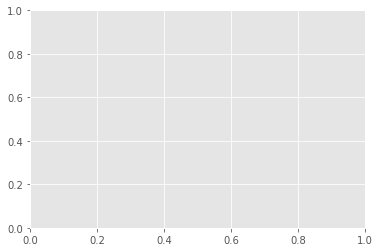

In [63]:
fig, ax = plt.subplots()
goodPerfoming_variance_proj = ['netvogue','Condominio','ROMS']

N = len(wide_variance_proj)
#TODO add the project RMSE only from wide_variance_proj
ind = np.arange(N)    # the x locations for the groups
width = 0.35         # the width of the bars
p1 = ax.bar(ind, rmse_unpool, width, color='r') #yerr =
p2 = ax.bar(ind + width, rmse_full_vary, width,color='y')
p3 = ax.bar(ind+2*width, rmse_pool, width, color='b')
ax.set_title('Unpooled vs Partial Pooled Errors (lower is better)')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(wide_variance_proj)

ax.legend((p1[0], p2[0], p3[0]), ('Unpooled', 'Partial Pool', 'Pooled'))
ax.yaxis.set_units('RMSE')
# ax.autoscale_view()


In [ ]:
# this is me trying to estimate the improvement. 
# not sure (in fact pretty sure the other way) this is legit.
overall = 0
for i in range(10):
    diff = rmse_pool[i] - rmse_full_vary[i]
    overall = overall + (diff * diff)
total_diff = overall/10 # mean error change
print(total_diff)
np.average(rmse_full_vary)


This is a measure of *training* error: we validate our model against the same data it was trained on. This is satisfactory since we are looking for a simple estimate as to how effective the pooling/partial pooling decision was. In statistical learning, however, it is customary to separate data into training/test/validation sets. The test data can be simulated using a k-fold validation, which leaves out one tranche of the data as a test set, trains the model on the other tranches (k-1) and then calculates predictive error with respect to the held-out tranche. For ultimate validation, of course, we should be using our model on an entirely different data set, and testing predictive error on this hitherto unknown data.

# Deriving Thresholds from Partial Pooling 
In the original paper, thresholds were derived as follows:
1. If there was no significant difference between a given role (Controller) and the rest of the non-controller classes, then stop. Significant is derived from the non-parametric tests above.
2. **"Weight Ratio Calculation"**: for classes with that role, normalize class importance using LOC (i.e., shorter classes have a lower weight).
3. Order classes by weight ration.
4. Assign each class a cumulative weight consisting of the weights from classes that have smaller metric values.
4. Extract thresholds: the threshold for medium/high/highest metric value is taken from the class with a cumulative weight closest to 70/80/90% of the total, respectively. 

Another way of doing this is made possible by the model of lognormal. Simply find the 70/80/90% thresholds on the posterior probability distribution (where percentage is "of the total probability mass")

In [ ]:
varying_intercept_slope_fit['sigma'].mean()

In [ ]:
fig, ax = plt.subplots(1, 1)

# V2V
# c = 'V2V'
# c='tatami-team1'
c='2gx_demo'
mean = slopes_partial[project_lookup[c]]+intercepts_partial[project_lookup[c]]
sigma = varying_intercept_slope_fit['sigma'].mean() #for all projects

proj_model = stats.norm(loc=mean,scale=sigma)
# norm_ys = proj_model.rvs(1000)
# exp_ys = np.exp(norm_ys)
# sns.distplot(exp_ys)

x = np.linspace(proj_model.ppf(0.001),proj_model.ppf(0.999), 100)
low=proj_model.ppf(0.7)
med=proj_model.ppf(0.8)
high=proj_model.ppf(0.9)
plt.axvline(x=low,color='r', linestyle=':')
plt.axvline(x=med,color='r', linestyle=':')
plt.axvline(x=high,color='r', linestyle=':')
ax.plot(x, proj_model.pdf(x), 'k-', lw=2, label='frozen pdf')
# the exponential of the thresholds is the actual CBO score. ROunded, since CBO cannot be fractional.
print("The CBO thresholds for {} are low: {:2.0f}; med: {:2.0f}; high: {:2.0f}".format(c,np.exp(low),np.exp(med),np.exp(high)))
#np.exp(mean)



## Other Ideas, not yet Implemented

## Cross Validation 
120 Projects

Train  | Valid | Test
80 Projects 20 20

We need projects to compute the partial pool
Therefore validation should be on held back code for the prohect. 

Hold back folds within project, split equally as 10% of controller/non-controller code\

for p in projects:
	length_p = len(final.query("project=='{1}'".format(p)))

or just go through all the files in order and you get some guarantee if you choose 10%? 



# Model Checking
To validate the model we have chosen (i.e., the one defined in the partial pooling model example), we should check that the data it produces - the posterior distribution - matches with what we expect.

<a id='spikezero'></a>
# Extension: Modeling the spike at Zero

In addition to log-normal characteristics, software metrics have a tendency to occasinally have a spike at zero. If an object is not used in the codebase, for example, it will have no coupling. We can't just discard these, since they are clearly symptomatic of something. 

As [this post](https://robjhyndman.com/hyndsight/transformations/) suggests, the approach taken above---taking log(n+1) - is probably ok, but does make some weirdness happen. In this section we examine how a *mixture model* can characterize what is happening. THe 'mixture' part is just the fact that we will model the zero spike separately from the rest of the data. 

## Extension: Modeling with Two Predictors
In our worked example, we only used a single predictor: architecutal role. However, we know from various studies that source lines of code are a common covariant with many software metrics. In the CBO (coupling) metric, we would expect that longer files would have more calls to external code, and thus more coupling. In this extension, we will apply a double predictor model to our previous models.

THe main cahnge is to use a matrix representation for our data, instead of a single value. Our matrix is 2 columns, one for the file's LOC measure, and one for the CBO measure. Our pooled regression model looks like

$ y_i = \alpha + \beta_1 \text{loc}_i + \beta_2 \text{cbo}_i + \epsilon $

see https://jrnold.github.io/bayesian_notes/introduction-to-stan-and-linear-regression.html

In [ ]:
find_fit.plot_fits(pandas.Series(log_sloc),title='SLOC scores with best fit distribution', xlab='SLOC score')

## Why Not KS (Kolmogorov-Smirnov)?
One way to assess model fit is to run a KS test of model fit. KS measures the distance between your sample data and the theoretical distribution. 

Thanks to https://seaborn.pydata.org/tutorial/categorical.html and https://github.com/fonnesbeck/stan_workshop_2016/blob/master/notebooks/Multilevel%20Modeling.ipynb